In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import os

os.chdir("/content/gdrive/MyDrive/Colab_Notebooks/ACDC_challenge/PFE/Dev")

In [5]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 12.3 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.4.0-py3-none-any.whl size=214964 sha256=43e4c67a8f4b90613e151e53a7c7fd2b88f1debc2400697fd2e1f50999ee2071
  Stored in directory: /root/.cache/pip/wheels/41/46/a2/7c585b78f216a3dd8723dbab5f439822fa5dfbff563757a49e
Successfully built medpy
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [6]:
# imports
import json
from metrics import diceLoss, DiceIndex
from constants import HOME_DIR
import tensorflow as tf
import numpy as np

In [9]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [10]:
# install tensorflow serving for python2
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb'
!dpkg -i tensorflow-model-server_2.8.0_all.deb
!pip3 install tensorflow-serving-api==2.8.0

--2023-04-15 18:47:54--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-2.8.0/t/tensorflow-model-server/tensorflow-model-server_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.217.128, 173.194.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340152790 (324M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server_2.8.0_all.deb.4’

tensorflow-model-se 100%[===================>] 324.39M  39.8MB/s    in 9.2s    

2023-04-15 18:48:04 (35.1 MB/s) - ‘tensorflow-model-server_2.8.0_all.deb.4’ saved [340152790/340152790]

Selecting previously unselected package tensorflow-model-server.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack tensorflow-model-server_2.8.0_all.deb ...
Unpacking tensorflow-model-server (2.8.0) ...
Setting up tensorflow-

In [7]:
def loss(y_true, y_pred):
  return diceLoss(y_pred,y_true) 

In [8]:
MODEL_DIR = HOME_DIR+'models/TF_serving'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /content/gdrive/MyDrive/Colab_Notebooks/ACDC_challenge/PFE/models/TF_serving/1



In [8]:
# Converting *.h5 model to SavedModel format
#filepath = HOME_DIR+'/models/cosine_per_epoch/snapshot_mcp_final_final_8_8.h5'
#model = tf.keras.models.load_model(filepath,custom_objects={"DiceIndex":DiceIndex, "loss":loss})

# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
#tf.keras.models.save_model(
#    model,
#    export_path,
#    overwrite=True,
#    include_optimizer=True,
#    save_format=None,
#    signatures=None,
#    options=None
#)

#print('\nSaved model:')
#!ls -l {export_path}

export_path = /content/gdrive/MyDrive/Colab_Notebooks/ACDC_challenge/PFE//models/TF_serving/1




Saved model:
total 2589
drwx------ 2 root root    4096 Apr 15 00:30 assets
-rw------- 1 root root      56 Apr 15 08:08 fingerprint.pb
-rw------- 1 root root  246562 Apr 15 08:08 keras_metadata.pb
-rw------- 1 root root 2395244 Apr 15 08:08 saved_model.pb
drwx------ 2 root root    4096 Apr 15 08:08 variables


In [ ]:
!saved_model_cli show --dir {export_path} --all

2023-04-14 21:42:43.411062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 128, 128, 1)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['activation_27'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 128, 128, 4)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/servin

In [11]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [12]:
# Creates model endpoint
# and start the server to listen for requests
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=mcpnet \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1


In [14]:
!tail server.log

2023-04-15 18:48:35.577389: E external/org_tensorflow/tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: NOT_FOUND: Op type not registered 'DisableCopyOnRead' in binary running on 95dbc870f91d. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.
	when importing GraphDef to MLIR module in GrapplerHook
2023-04-15 18:48:39.195396: E external/org_tensorflow/tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: NOT_FOUND: Op type not registered 'DisableCopyOnRead' in binary running on 95dbc870f91d. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.co

### Send REST client requests

In [16]:
os.chdir("/content/gdrive/MyDrive/Colab_Notebooks/ACDC_challenge/PFE/")

In [19]:
from rest_client_serving import(
    get_model_endpoint,
    load_test_data,
    get_model_prediction,
    display_image)
import matplotlib.pyplot as plt

Generate REST model endpoint ...
http://127.0.0.1:8501/v1/models/mcpnet:predict


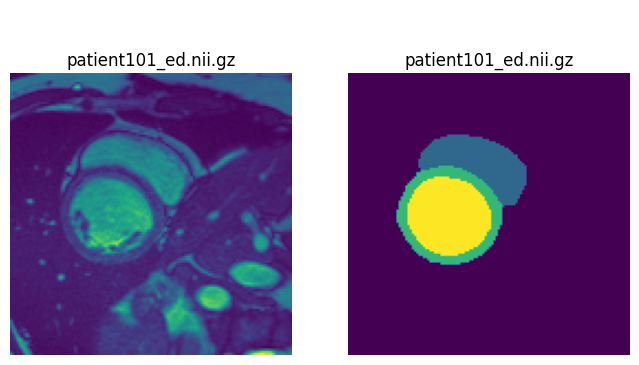

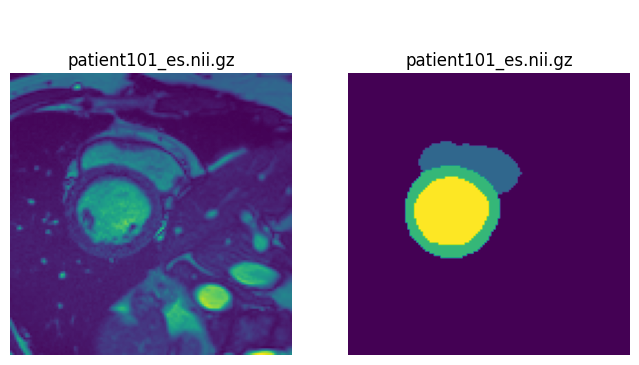

In [84]:
print("Generate REST model endpoint ...")
url = get_model_endpoint(model_name='mcpnet')
print(url)

nb_samples = 2
data_path ="./Test/data/"
test_data,files,_,_ = load_test_data(data_path,nb_samples)
for idx,model_input in enumerate(test_data):
  model_prediction = get_model_prediction(model_input)
  display_image(3,f'{files[idx]}',model_input,model_prediction)
